For survival:

0 died 1 lived

For gender:

0 male 1 female

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier # Import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report # Import confusion_matrix and classification_report


drive.mount('/content/drive')
gender_submission_df = "/content/drive/MyDrive/Python course files/gender_submission.csv"
train_df = "/content/drive/MyDrive/Python course files/train.csv"
test_df = "/content/drive/MyDrive/Python course files/test.csv"

# Load the data into pandas DataFrames
gender_submission_df = pd.read_csv(gender_submission_df)
train_df = pd.read_csv(train_df)
test_df = pd.read_csv(test_df)

# Add survival labels to test set
test_with_labels = test_df.merge(gender_submission_df, on='PassengerId')

# Add a column to keep track of where each row came from
train_df['Dataset'] = 'train'
test_with_labels['Dataset'] = 'test'

# Combine train and labeled test sets
combined_df = pd.concat([train_df, test_with_labels], ignore_index=True)

# Final check
print(combined_df.shape)
combined_df.head()


#combined_df.to_csv('combined.csv', index=False)
#from google.colab import files
#files.download('combined.csv')


Mounted at /content/drive
(1309, 13)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


In [ ]:
combined_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  Dataset      1309 non-null   object 
dtypes: float64(2), int64(5), object(6)
memory usage: 133.1+ KB


In [ ]:
#combined_df["Sex"] = combined_df["Sex"].map({"male": 0 , "female": 1})
combined_df["Sex"] = combined_df["Sex"].str.strip().str.lower().map({"male": 0, "female": 1})
features = ["Pclass", "Sex", "Age", "SibSp","Parch", "Fare"] # choose which independent variables I will focus on
X = combined_df[features] # place features into the x
y = combined_df["Survived"] # revenue is the dependent variable I will be predicting

X = X.fillna(X.mean())


Reduced Data Shape: (1309, 4)


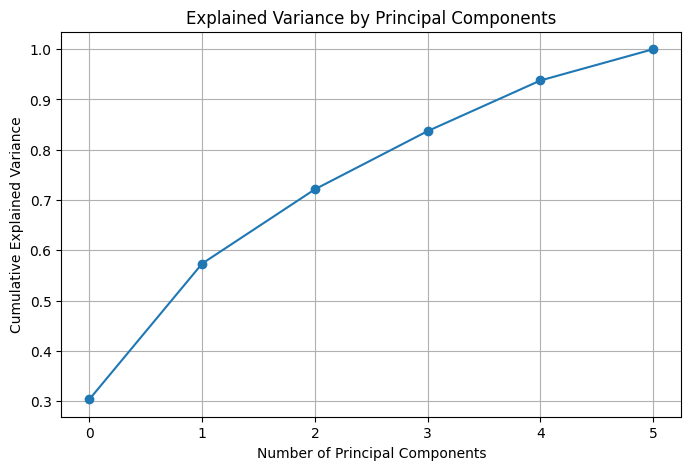

Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       159
           1       0.82      0.79      0.80       103

    accuracy                           0.85       262
   macro avg       0.84      0.84      0.84       262
weighted avg       0.85      0.85      0.85       262

Confusion Matrix:
[[141  18]
 [ 22  81]]


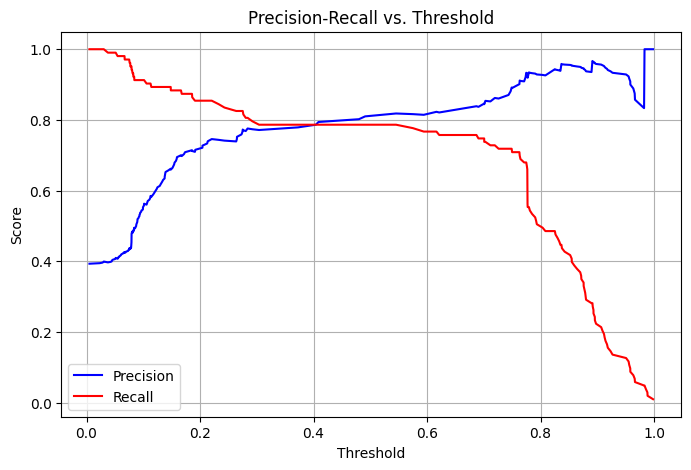

In [ ]:
  # Standardize features (important for PCA)
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Apply PCA (reduce to 3 principal components based on the wnating to explain at least 90%)
  pca = PCA(n_components=4)
  X_pca = pca.fit_transform(X_scaled)

  # Convert to DataFrame
  pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2","PC3", "PC4"])

  print("Reduced Data Shape:", X_pca.shape)

  # Plot cumulative explained variance
  plt.figure(figsize=(8, 5))
  plt.plot(np.cumsum(PCA(n_components=len(X.columns)).fit(X_scaled).explained_variance_ratio_), marker='o')
  plt.xlabel("Number of Principal Components")
  plt.ylabel("Cumulative Explained Variance")
  plt.title("Explained Variance by Principal Components")
  plt.grid()
  plt.show()

  X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
  log_model = LogisticRegression()
  log_model.fit(X_train, y_train)

  y_prob = log_model.predict_proba(X_test)[:, 1]  # Probability of class 1


  threshold = 0.5  # Lowering threshold increases recall

  # Convert probabilities into binary predictions using the threshold
  y_pred_adjusted = (y_prob >= threshold).astype(int)

  print(f"Classification Report (Threshold = {threshold}):")
  print(classification_report(y_test, y_pred_adjusted))
  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred_adjusted))




# Compute precision-recall values for different thresholds
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Plot Precision-Recall vs. Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs. Threshold")
plt.legend()
plt.grid()
plt.show()

## Random Forest

In [ ]:
# Start of Random Forest

features = ["Pclass", "Sex", "Age", "SibSp","Parch", "Fare"] # Relevant features that we chose.
combined_df = combined_df[features + ['Survived']] # only keeping the necessary features.
#df['Age'].fillna(df['Age'].mean(), inplace=True)

combined_df['Sex'] = LabelEncoder().fit_transform(combined_df['Sex']) # Converts categorical to numeric through encoding

X = combined_df.drop('Survived', axis=1) #axis=1 means drop columns, axis=0 means drop rows
y = combined_df['Survived'] # setting y as the target variable 'Survived'

<ipython-input-3-740fa0d6abe5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['Sex'] = LabelEncoder().fit_transform(combined_df['Sex']) # Converts categorical to numeric through encoding


In [ ]:
#Training for Random Forest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Splitting training/test. using 70/30 split.

rf = RandomForestClassifier(random_state=42, oob_score=True) # implementing 'out of bag' score as a sort of cross validator
rf.fit(X_train, y_train)
rf.fit(X, y)
print(rf.oob_score_) # prints out of bag score

y_pred = rf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



0.8357211079274116
Confusion Matrix:
[[135  24]
 [ 24  79]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       159
           1       0.77      0.77      0.77       103

    accuracy                           0.82       262
   macro avg       0.81      0.81      0.81       262
weighted avg       0.82      0.82      0.82       262



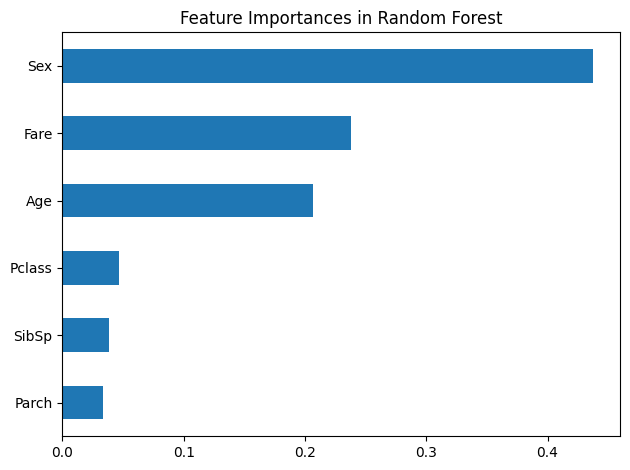

In [ ]:
# Feature importance graph

import matplotlib.pyplot as plt # imports matplotlib Library

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh') # sorts from least to most important
plt.title("Feature Importances in Random Forest") # adds title
plt.tight_layout()
plt.show() # displays plot

In [ ]:
# Optimal Feature Selection

from sklearn.feature_selection import RFECV # Import RFECV (Recursive Feature Elimination with Cross-Validation)
from sklearn.ensemble import RandomForestClassifier # import Random forest model

rf = RandomForestClassifier(n_estimators=50, random_state=42) # Create a Random Forest classifier with 50 trees (estimators) and set a random seed (42)
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='recall') # Set up RFECV to select the best features:
rfecv.fit(X_train, y_train) # Ran RFECV on the training data to find the best features

print("Optimal number of features:", rfecv.n_features_) # Print how many features were selected as optimal
print("Selected features:", X_train.columns[rfecv.support_])

Optimal number of features: 2
Selected features: Index(['Sex', 'Fare'], dtype='object')


In [ ]:
# Hyperparameter Selection

from sklearn.model_selection import GridSearchCV # Import GridSearchCV, a tool to search for the best hyperparameters for a model
params = {'n_estimators': [10, 15, 20], 'max_depth': [3, 5, 10]} # Create a dictionary of parameters to test
gs = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5) # Sets up GridSearchCV
gs.fit(X_train, y_train) # Fit the model to the training data, testing all the parameter combinations to find the best one
print(gs.best_params_)

{'max_depth': 5, 'n_estimators': 15}


Model 2 Starts Here: Leaner Model.

In [ ]:
# Start of Pruned Random Forest

features = ["Sex", "Age", "Fare"] # Defined the list of features we kept: 'Sex', 'Age', and 'Fare'
combined_df = combined_df[features + ['Survived']] # Kept only the selected features and the target column ('Survived') in the dataframe

#df['Age'].fillna(df['Age'].mean(), inplace=True)

combined_df['Sex'] = LabelEncoder().fit_transform(combined_df['Sex']) # Convert the 'Sex' column from text ('male', 'female') into numbers

X = combined_df.drop('Survived', axis=1) #axis=1 means drop columns, axis=0 means drop rows
y = combined_df['Survived']

<ipython-input-10-e118e48a75df>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['Sex'] = LabelEncoder().fit_transform(combined_df['Sex'])


In [ ]:
#Training for Random Forest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42, oob_score=True)
rf.fit(X_train, y_train)
rf.fit(X, y)
print(rf.oob_score_)

y_pred = rf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



0.828113063407181
Confusion Matrix:
[[157   2]
 [  3 100]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       159
           1       0.98      0.97      0.98       103

    accuracy                           0.98       262
   macro avg       0.98      0.98      0.98       262
weighted avg       0.98      0.98      0.98       262



# Model 3: Implementing Hyperparameters.

In [ ]:
# Start of Pruned Random Forest

features = ["Sex", "Age", "Fare"]
combined_df = combined_df[features + ['Survived']]

#df['Age'].fillna(df['Age'].mean(), inplace=True)

combined_df['Sex'] = LabelEncoder().fit_transform(combined_df['Sex'])

X = combined_df.drop('Survived', axis=1) #axis=1 means drop columns, axis=0 means drop rows
y = combined_df['Survived']

In [ ]:
# newly-implemented max depth and n-estimators

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split the data into training and testing sets 80/20

rf = RandomForestClassifier(max_depth=5, n_estimators=15, random_state=42, oob_score=True)
# Create a Random Forest classifier:
#- max_depth=5 limits each tree’s depth
# - n_estimators=15 means the forest has 15 trees
# - random_state=42 for consistent results
#- oob_score=True enables out-of-bag (OOB) score calculation

rf.fit(X_train, y_train)
rf.fit(X, y)
print(rf.oob_score_)

y_pred = rf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


0.8487394957983193
Confusion Matrix:
[[143  16]
 [ 20  83]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       159
           1       0.84      0.81      0.82       103

    accuracy                           0.86       262
   macro avg       0.86      0.85      0.85       262
weighted avg       0.86      0.86      0.86       262



/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
